# Dependency RNNs

To try to embed words and dependency relations s.t. they are predictive of relations, consider using a simple RNN or LSTM/GRU to predict the target noun

In [306]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import collections
from __future__ import print_function
import random
from time import time

# plot settings
% matplotlib inline
# print(plt.rcParams.keys())
plt.rcParams['figure.figsize'] = (16,9)

In [7]:
from spacy import English
nlp = English()

## Dataset Curation

In [235]:
split_delims = [' ',',','.',';',':', '%', '"', '$', '^']
def split(string, delimiters=split_delims, maxsplit=0):
    regexPattern = '|'.join(map(re.escape, delimiters))
    return re.split(regexPattern, string, maxsplit)

def convert_raw_x(line):
    """Convert raw line of semeval data into a useable form
    
    Convert to a triple of (list(raw words), e1_index, e2_index)
    """
    s = line.strip()
    #print(s)
    s = s[s.index('"')+1: -(s[::-1].index('"')+1)] # get s between first " and last "
    # we will assume that the first token follow the <e1> , <e2> tags are the entity words.  
    # note this is a big assumption and hopefully phrases will be in subtrees or in heads of the parse trees
    # TODO: this can be addressed by making it a 5-tuple with the endpoints also encoded
    s = [ w for w in split(s) if w is not '' ]
    for i in range(len(s)):
        # deal with e1's
        if '<e1>' in s[i]:
            e1_index = i
            s[i] = s[i].replace('<e1>', '')
        if '</e1>' in s[i]:
            #e1_index = i
            s[i] = s[i].replace('</e1>', '')
        # eal with e2's
        if '<e2>' in s[i]:
            e2_index = i
            s[i] = s[i].replace('<e2>', '')
        if '</e2>' in s[i]:
            #e2_index = i
            s[i] = s[i].replace('</e2>', '')
        
    # drop extraneous elements from re.split
    # also turn it into a spacy sentence
    s = nlp(u' '.join([ w.lower() for w in s ])) 
    return (s, e1_index, e2_index)
    
label2int = dict() # keep running dictionary of labels
def convert_raw_y(label_line):
    """Convert raw line of semeval labels into a useable form (ints)"""
#     print("Raw Y: %r" % line[:])
    line = label_line.strip()
    if line in label2int:
        return label2int[line]
    else:
        label2int[line] = len(label2int.keys())
        return label2int[line]
    
def lookup_inverse_relation(relation_int):
    if relation_int in int2label:
        label = int2label[relation_int]
        if label == 'Other':
            return relation_int
        else:
            rel, ex, ey = re.split("\(|,|\)", label)[:3]
            label = ''.join([rel, '(', ey, ',', ex,')'])
            return label2int[label]
    else:
        print("Label with that index doesn't exist")
        
def load_semeval_data():
    """Load in SemEval 2010 Task 8 Training file and return lists of tuples:
    
    Tuple form =  (spacy(stripped sentence), index of e1, index of e2)"""
    training_txt_file = 'SemEval2010_task8_all_data/SemEval2010_task8_training/TRAIN_FILE.TXT'
    validation_index = 8000 - 891# len data - len valid - 1 since we start at 0
    train = {'x':[], 'y':[]}
    valid = {'x':[], 'y':[]}
    text = open(training_txt_file, 'r').readlines()
    assert len(text) // 4 == 8000
    for cursor in range(len(text) // 4): # each 4 lines is a datum
        if cursor < validation_index:
            train['x'].append(convert_raw_x(text[cursor*4]))
#             print(cursor, convert_raw_x(text[cursor*4]))
            train['y'].append(convert_raw_y(text[cursor*4 + 1]))
            # ignore comments and blanks (+2, +3)
        else:
            valid['x'].append(convert_raw_x(text[cursor*4]))
            valid['y'].append(convert_raw_y(text[cursor*4 + 1]))
            
    assert len(train['y']) == 7109 and len(valid['y']) == 891
    assert sorted(label2int.values()) == range(19) # 2 for each 9 asymmetric relations and 1 other
    
    return train, valid
    
semeval_train, semeval_valid = load_semeval_data()
int2label = {v:k for (k,v) in label2int.items()}

In [236]:
# get a quick sense of the data
for i in range(5):
    s, e1, e2 = semeval_train['x'][i]
    print("%r (%i, %i) :: %r\n" % (s, e1, e2, int2label[semeval_train['y'][i]]))

the system as described above has its greatest application in an arrayed configuration of antenna elements (12, 15) :: 'Component-Whole(e2,e1)'

the child was carefully wrapped and bound into the cradle by means of a cord (1, 9) :: 'Other'

the author of a keygen uses a disassembler to look at the raw assembly code (1, 7) :: 'Instrument-Agency(e2,e1)'

a misty ridge uprises from the surge (2, 6) :: 'Other'

the student association is the voice of the undergraduate student population of the state university of new york at buffalo (1, 2) :: 'Member-Collection(e1,e2)'



In [237]:
# create a vocab and dependency vocab
vocab_size = 7000
def create_vocab_from_data(sentences, vocab_limit=5000, dep=False, print_oov=True):
    """Create a vocab index, inverse index, and multinomial distribution over tokens from a list of spacy sentences
    
    if `dep`=True, return the dependencies instead of the tokens"""
    counts = collections.Counter()
    for sentence in sentences:
        for token in sentence:
            if dep:
                counts[token.dep_] += 1
            else:
                if not token.is_oov and token.text not in [u' ', u'\n\n']:
                    counts[token.text] += 1
                elif print_oov:
                    print("Token %r is oov" % token.text)
                
    # make sure we didn't aim too high
    if vocab_limit > len(counts):
        vocab_limit = len(counts)
    # create the vocab in most common order
    vocab = [ x[0] for x in counts.most_common() ][:vocab_limit]
    counts_ordered = [ x[1] for x in counts.most_common() ][:vocab_limit]
    # calculate the empirical distribution
    unigram_distribution = list(np.array(counts_ordered) / np.sum(counts_ordered, dtype=np.float32))
    # create index and inverted index
    vocab2int = { token:i for (i, token) in enumerate(vocab) }
    int2vocab = { i:token for (token, i) in vocab2int.items() }

    return vocab, vocab2int, int2vocab, unigram_distribution

(vocab, vocab2int, int2vocab, vocab_dist) = (create_vocab_from_data(
                                                  [datum[0] for datum in (semeval_train['x']+semeval_valid['x'])],
                                                  vocab_limit=vocab_size))
assert len(vocab) == vocab_size, "We don't have enough embeddings for those"
vocab_set = set(vocab)
(dep_vocab, dep2int, int2dep, dep_dist) = (create_vocab_from_data(
                                                  [datum[0] for datum in (semeval_train['x']+semeval_valid['x'])],
                                                  vocab_limit=50,
                                                  dep=True))
dep_set = set(dep_vocab)

Token u'uprises' is oov
Token u'helicobacter' is oov
Token u'lawsonite' is oov
Token u'pipetted' is oov
Token u'quispel' is oov
Token u'enfeoffing' is oov
Token u'shahrestan' is oov
Token u'bakhsh' is oov
Token u'dehestan' is oov
Token u'newsgator' is oov
Token u'infinitival' is oov
Token u'perseid' is oov
Token u'juliano' is oov
Token u'eulito' is oov
Token u'cowpea' is oov
Token u'cieply' is oov
Token u'desulphurization' is oov
Token u'grunion' is oov
Token u'uncomplexed' is oov
Token u'ligneul' is oov
Token u'lignoul' is oov
Token u'allraline' is oov
Token u'languages(notably' is oov
Token u'igenition' is oov
Token u'klebsiella' is oov
Token u'serratia' is oov
Token u'providencia' is oov
Token u'gashouder' is oov
Token u'imfl' is oov
Token u'guimaras' is oov
Token u'arbuzov' is oov
Token u'gondorians' is oov
Token u'gondorians' is oov
Token u'andflavor' is oov
Token u'organization(who' is oov
Token u'mapungubwe' is oov
Token u'mapungubwe' is oov
Token u'shashe' is oov
Token u'associ

In [238]:
# drop any data item that contains an oov word
def is_oov(sentence, vocab_set):
    for token in sentence:
        if token.text not in vocab_set:
            return True
    return False

print("Before OOV: %i training sentences and %i validation" % (len(semeval_train['x']), len(semeval_valid['x'])))
semeval_train['x'], semeval_train['y'] = zip(*[ (datum, label) for (datum, label) 
                                                in zip(semeval_train['x'], semeval_train['y'])
                                                if not is_oov(datum[0], vocab_set)])
semeval_valid['x'], semeval_valid['y'] = zip(*[ (datum, label) for (datum, label) 
                                                in zip(semeval_valid['x'], semeval_valid['y'])
                                                if not is_oov(datum[0], vocab_set)])
print("After OOV: %i training sentences and %i validation" % (len(semeval_train['x']), len(semeval_valid['x'])))

Before OOV: 7109 training sentences and 891 validation
After OOV: 1682 training sentences and 190 validation


In [239]:
def dependency_path_to_root(token):
    """Traverse up the dependency tree. Include the token we are tracing"""
    dep_path = [token]
    while token.head is not token:
        dep_path.append(token.head)
        token = token.head
    dep_path.append(token.head) # add the root node
    return dep_path

def convert_semeval_to_sdps(data, labels, include_deps=False, include_reverse=True, print_check=False):
    """Conver list of (spacy, e1 index, e2 index) into list of lists of shortest dependency path sequences
    
    if `include_deps`, each datum is a tuple of tokens and their dependencies
    """
    sdps = []
    new_labels = []
    for i, (sentence, e1_idx, e2_idx) in enumerate(data):
        e1 = sentence[e1_idx]
        e2 = sentence[e2_idx]
        e1_path = dependency_path_to_root(e1)
        e2_path = dependency_path_to_root(e2)       
        # find common ancestor for both e1 and e2
        # just loop over both, checking if inner is in outer
        # the first token meeting this is the least common ancestor
        common_ancestor = None
        for t1 in e1_path:
            for t2 in e2_path:
                if t1 is t2:
#                     print(t1, t2)
                    common_ancestor = t1
                    break
        assert common_ancestor is not None, "Didn't even find the common root node?"
        sdp = []
        for token in e1_path:
            if include_deps:
                sdp.append((vocab2int[token.text], dep2int[token.dep_]))
            else:
                sdp.append(vocab2int[token.text])
            if token is common_ancestor:
                break
        temp_sdp = []
        for token in e2_path:
            # this time go up to BUT not including common acestor
            if token is common_ancestor:
                break
            if include_deps:
                temp_sdp.append((vocab2int[token.text], dep2int[token.dep_]))
            else:
                temp_sdp.append(vocab2int[token.text])
        
        sdp.extend(list(reversed(temp_sdp))) # reverse the order since we traversed right to left for e2
        sdps.append(sdp)
        new_labels.append(labels[i])
        if include_reverse:
            sdps.append(list(reversed(sdp)))
            new_labels.append(lookup_inverse_relation(labels[i]))
        if print_check:
            print("%r (%i, %i)" % (list(sentence), e1_idx, e2_idx)) 
            print("%r" % [int2vocab[idx] for idx in sdp])
            print("%r" % sdp)
            if include_reverse:
                print("%r" % [int2vocab[idx] for idx in reversed(sdp)])
                print("%r\n" % list(reversed(sdp)))
            print('\n')
    return sdps, new_labels
            

train_x, train_y = convert_semeval_to_sdps(semeval_train['x'], semeval_train['y'], 
                                           include_reverse=True, 
                                           print_check=False)
valid_x, valid_y = convert_semeval_to_sdps(semeval_valid['x'], semeval_valid['y'], 
                                           include_reverse=True, 
                                           print_check=False)

# Model instantiation and training

In [277]:
# a helper function for negative sampling
def sample_distribution(distribution):
    """Sample one element from a distribution assumed to be an array of normalized
    probabilities.
    """
    r = random.uniform(0, 1)
    s = 0
    for i in range(len(distribution)):
        s += distribution[i]
        if s >= r:
            return i
    return len(distribution) - 1

def distribution_to_power(distribution, power):
    """Return a distribution, scaled to some power"""
    dist = [ pow(d, power) for d in distribution ]
    dist /= np.sum(dist)
    return dist

In [241]:
max_sequence_len = max([len(x) for x in (train_x+valid_x)])
print("Max Sequence Length: %i" % max_sequence_len)

Max Sequence Length: 24


In [355]:
# num_true = 100
# negative_per = 5
# batch_size = num_true*(negative_per + 1)


batch_size = 20
negative_per = 25*batch_size
max_steps = max_sequence_len
num_units = 300 # size of hidden state in rnn
embedding_size = 300 # size of input embeddings

# create the embeddings matrix we'll use as a constant in the graph
levy_embeddings = np.zeros(shape=[vocab_size, embedding_size], dtype=np.float32)
for word in vocab:
    token = nlp.tokenizer(word)
    levy_embeddings[vocab2int[word],:] = token.vector

# create the computation graph
graph = tf.Graph()   
with graph.as_default():
    # sequences placeholders
    seq_input = tf.placeholder(tf.int32, [batch_size, max_steps])
    seq_lengths = tf.placeholder(tf.int32, [batch_size])
    seq_labels = tf.placeholder(tf.float32, [batch_size, 1])
    
    
    # word embeddings lookup matrix
    word_embeddings = tf.Variable(levy_embeddings)
    
    # prediction softmax wegiths and biases
    weights = tf.Variable(tf.random_uniform([vocab_size, num_units],
                                             minval=-1.0, maxval=-1.0,
                                             dtype=tf.float32))
    biases = tf.Variable(tf.zeros([vocab_size]))
    
    # create the sequence as a list([batch_size, embedding_size])
    # look up the embeddings given the word indices
    sequences = []
    for time_step in tf.split(1, max_steps, seq_input):
        embedded_step = tf.nn.embedding_lookup(word_embeddings, time_step)
        sequences.append(tf.squeeze(embedded_step))
    
    # rnn cell style
    cell = tf.nn.rnn_cell.GRUCell(num_units, input_size=embedding_size)
    
    # run the actual rnn. thankfully rnn now implements
    outputs, state = tf.nn.rnn(cell, sequences, 
                         sequence_length=seq_lengths, 
                         initial_state=None, 
                         dtype=tf.float32)
    sampler = tf.nn.fixed_unigram_candidate_sampler(true_classes=tf.to_int64(seq_labels),
                                                    num_true=1,
                                                    num_sampled=negative_per,
                                                    unique=True,
                                                    range_max=vocab_size,
                                                    distortion=.75,
                                                    unigrams=vocab_dist)
    loss = tf.nn.nce_loss(weights, biases, state, seq_labels,
                          num_sampled=negative_per,
                          num_classes=vocab_size,
                          sampled_values=sampler)
    
    objective = tf.reduce_mean(loss)
    
    optimizer = tf.train.AdagradOptimizer(1.0)
    
    grads_and_vars = optimizer.compute_gradients(objective)
    clipped_grads_and_vars = [(tf.clip_by_norm(gv[0], 1.), gv[1]) for gv in grads_and_vars]
    minimizer = optimizer.apply_gradients(clipped_grads_and_vars)


In [357]:
session.close()
scaled_vocab_dist = distribution_to_power(vocab_dist, .75)

session = tf.InteractiveSession(graph=graph)
# initialize the graph
tf.initialize_all_variables().run()
print('Initialized')          

losses = []
num_epochs = 20
start = time()
for epoch in range(num_epochs):
    for step in range(10000):
        feed_sequences = np.zeros([batch_size, max_steps])
        feed_lengths = np.zeros([batch_size])
        feed_labels = np.zeros([batch_size, 1], dtype=np.float32)

        start = batch_size*step
        end = min(start + batch_size, len(train_x))
        for i, sequence in enumerate(train_x[start:end]):
            sequence_length = len(sequence)
            feed_sequences[i, :sequence_length] = sequence
            feed_lengths[i] = sequence_length
            feed_labels[i] = 1.0
            # add in the negative samples
            # currently just replace the final word 
            # with a random vocab word
        #     for j in range(negative_per):
        #         sequence[-1] = sample_distribution(scaled_vocab_dist)
        #         neg_index = num_true + i*negative_per + j
        #         feed_sequences[neg_index, :sequence_length] = sequence
        #         feed_lengths[neg_index] = sequence_length


        feed_dict = {seq_input:feed_sequences, seq_lengths:feed_lengths, seq_labels:feed_labels}
        _, loss = session.run([minimizer, objective], feed_dict=feed_dict)
        losses.append(loss)
        if step % 10 == 0 and step != 0:
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
            avg_loss = np.sum(losses) / float(len(losses))
            print("(%i:%i:%i) Avg losses at step %i, epoch %i: %0.4f" 
                  % (h,m,s, step, epoch, avg_loss))
        if end >= len(train_x):
            break
print("Done Training")

Initialized
(404576:13:36) Avg losses at step 10, epoch 0: 278.8198
(404576:10:17) Avg losses at step 20, epoch 0: 147.9270
(404576:6:58) Avg losses at step 30, epoch 0: 100.6844
(404576:3:39) Avg losses at step 40, epoch 0: 76.4669
(404576:0:20) Avg losses at step 50, epoch 0: 61.7461
(404575:57:1) Avg losses at step 60, epoch 0: 51.8518
(404575:53:42) Avg losses at step 70, epoch 0: 44.7445
(404575:50:23) Avg losses at step 80, epoch 0: 39.3924
(404575:47:3) Avg losses at step 90, epoch 0: 35.2165
(404575:43:44) Avg losses at step 100, epoch 0: 31.8671
(404575:40:25) Avg losses at step 110, epoch 0: 29.1215
(404575:37:6) Avg losses at step 120, epoch 0: 26.8296
(404575:33:47) Avg losses at step 130, epoch 0: 24.8875
(404575:30:28) Avg losses at step 140, epoch 0: 23.2210
(404575:27:9) Avg losses at step 150, epoch 0: 21.7752
(404575:23:50) Avg losses at step 160, epoch 0: 20.5092
(404576:13:51) Avg losses at step 10, epoch 1: 23.8162
(404576:10:32) Avg losses at step 20, epoch 1: 22.

In [366]:
embeddings = word_embeddings.eval()
gru = cell

In [375]:
def gru_transform(sequence):
    

TypeError: 'GRUCell' object has no attribute '__getitem__'

In [363]:
num_points = 100
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=5, n_components=2, 
            init='pca', n_iter=5000,
            verbose=1,
            learning_rate=100,
            random_state=0)
nn_2d_embeddings = tsne.fit_transform(embeddings[:num_points])
levy_2d_embeddings = tsne.fit_transform(levy_embeddings[:num_points])

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.304908
[t-SNE] Error after 100 iterations with early exaggeration: 0.443837
[t-SNE] Error after 175 iterations: 0.433393
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.285967
[t-SNE] Error after 100 iterations with early exaggeration: 0.431976
[t-SNE] Error after 175 iterations: 0.420604


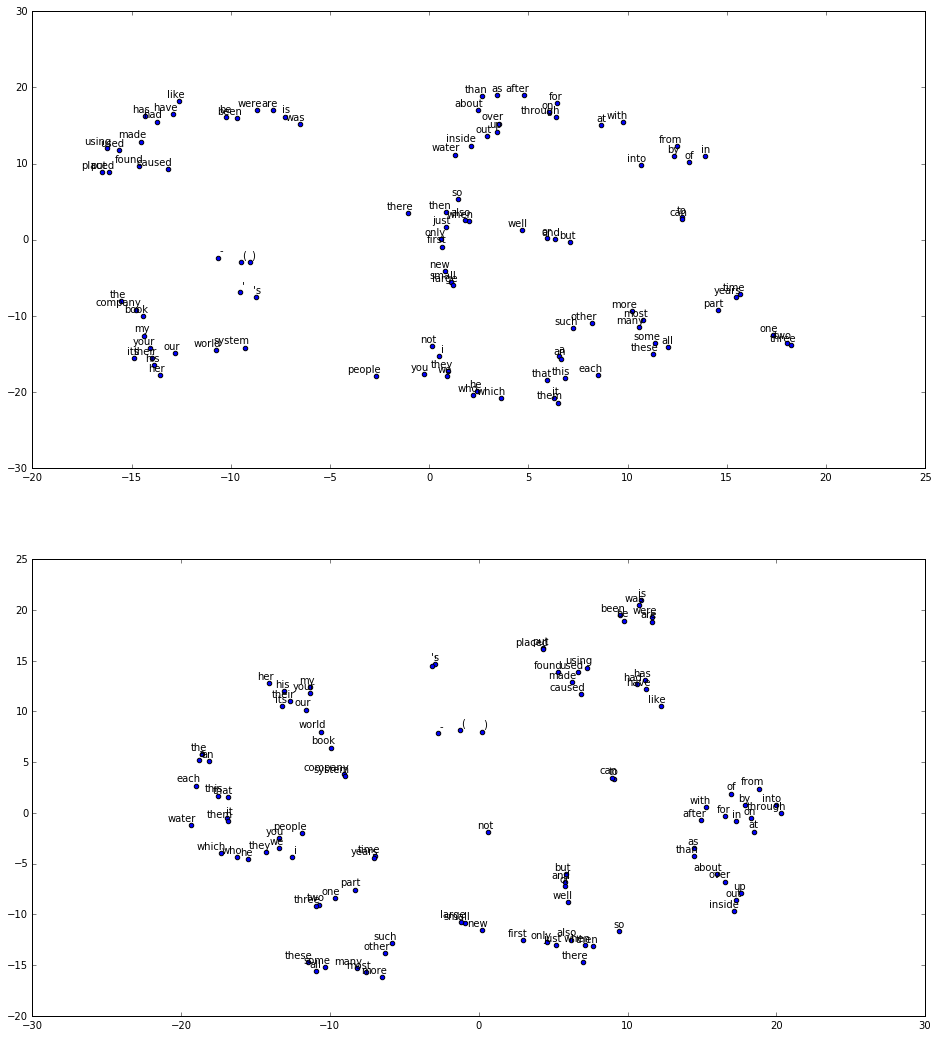

In [364]:
fig, (ax0, ax1) = plt.subplots(2,1,figsize=(16,18))

for i, label in enumerate(vocab[:num_points]):
    x, y = nn_2d_embeddings[i,:]
    ax0.scatter(x, y)
    ax0.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    
for i, label in enumerate(vocab[:num_points]):
    x, y = levy_2d_embeddings[i,:]
    ax1.scatter(x, y)
    ax1.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')

In [424]:
class DependencyRNN(object):
    """Encapsulate RNN"""
    def __init__(self, vocab_dist=None, name="drnn", embedding_size=300, hidden_size=300, nce_sample_size=25, sample_distortion=.75):
        if not vocab_dist:
            raise Exception("Must supply a distribution over the vocab")
        # parameters
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.vocab_dist = vocab_dist
        self.vocab_size = len(vocab_dist)
        self.nce_sample_size = nce_sample_size
        self.sample_distortion = sample_distortion
        self.name = name
        
        self.losses = []
        
        self._build_graph()
        
        init_op = tf.initialize_all_variables()
        self.session = tf.InteractiveSession()
        self.session.run(init_op)        
        
    def _build_graph(self):
        ### VARIABLES ###
        # word embeddings lookup matrix
#         with self.scope as scope:
        self.word_embeddings = tf.Variable(tf.truncated_normal([self.vocab_size, self.embedding_size]))

        # prediction softmax wegiths and biases
        self.weights = tf.Variable(tf.random_uniform([self.vocab_size, self.hidden_size],
                                                 minval=-1.0, maxval=-1.0,
                                                 dtype=tf.float32))
        biases = tf.Variable(tf.zeros([self.vocab_size]))

        ### RNN CELL ###
        self.cell = tf.nn.rnn_cell.GRUCell(self.hidden_size, input_size=self.embedding_size)

        ### OPTIMIZER ###
        self.optimizer = tf.train.AdagradOptimizer(1.0)  

        # for saving variables
        self.saver = tf.train.Saver()

    def _build_eval_graph(self):
        pass
        
    def partial_fit(self, seq_list):
        # get batch params
        batch_size = len(seq_list)
        seq_lens = [len(seq) for seq in seq_list]
        max_seq_len = max(seq_lens)
        
        ### Create the batch specific part of the graph ###
        tf.get_variable_scope().reuse_variables()
        seq_input = tf.placeholder(tf.int32, [batch_size, max_seq_len])
        seq_lengths = tf.placeholder(tf.int32, [batch_size])
        seq_labels = tf.placeholder(tf.float32, [batch_size, 1])

        # unroll the seequences and look up embeddings
        sequences = []
        for time_step in tf.split(1, max_seq_len, seq_input):
            embedded_step = tf.nn.embedding_lookup(self.word_embeddings, time_step)
            sequences.append(tf.squeeze(embedded_step))

        # run the rnn on the batch
        outputs, state = tf.nn.rnn(self.cell, sequences, 
                         sequence_length=seq_lengths, 
                         initial_state=None,
                         dtype=tf.float32)

        # sample negative examples
        samples = tf.nn.fixed_unigram_candidate_sampler(true_classes=tf.to_int64(seq_labels),
                                                    num_true=1,
                                                    num_sampled=self.nce_sample_size,
                                                    unique=True,
                                                    range_max=self.vocab_size,
                                                    distortion=self.sample_distortion,
                                                    unigrams=vocab_dist)  
        # calculate the nce loss objective
        loss = tf.nn.nce_loss(weights, biases, state, seq_labels,
                          num_sampled=negative_per,
                          num_classes=vocab_size,
                          sampled_values=sampler)

        # minimize avg sum of batch losses (should this denominator include negative samples?)
        objective = tf.mul(1./batch_size, tf.reduce_sum(loss))

        # clip and apply gradients
        grads_and_vars = self.optimizer.compute_gradients(objective)
        clipped_grads_and_vars = [(tf.clip_by_norm(gv[0], 1.), gv[1]) for gv in grads_and_vars]
        minimizer = self.optimizer.apply_gradients(clipped_grads_and_vars)

        ### Run the fit ###
        # format inputs
        feed_sequences = np.zeros([batch_size, max_seq_len])
        feed_lengths = np.zeros([batch_size])
        feed_labels = np.zeros([batch_size, 1], dtype=np.float32)
        for i, sequence in enumerate(seq_list):
            sequence_length = len(sequence)
            feed_sequences[i, :sequence_length] = sequence
            feed_lengths[i] = sequence_length
            feed_labels[i] = 1.0 
        feed_dict = {seq_input:feed_sequences, seq_lengths:feed_lengths, seq_labels:feed_labels}
        _, loss = self.session.run([minimizer, loss], feed_dict=feed_dict)
        self.losses.append(loss)
    
    def predict(self):
        pass
    
    def close(self):
        self.session.close()

In [427]:
tf.get_default_session().close()
drnn.session.close()

In [428]:
drnn = DependencyRNN(vocab_dist)

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_7' with dtype int32 and shape [100]
	 [[Node: Placeholder_7 = Placeholder[dtype=DT_INT32, shape=[100], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]
Caused by op u'Placeholder_7', defined at:
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/traitlets/config/application.py", line 589, in launch_instance
    app.start()
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 440, in start
    ioloop.IOLoop.instance().start()
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2831, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-404-175b29b41ed3>", line 1, in <module>
    drnn.partial_fit(train_x[:100])
  File "<ipython-input-401-56555d7a6a23>", line 56, in partial_fit
    seq_lengths = tf.placeholder(tf.int32, [batch_size])
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 742, in placeholder
    name=name)
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 583, in _placeholder
    name=name)
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/tensorflow/python/ops/op_def_library.py", line 655, in apply_op
    op_def=op_def)
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2040, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1087, in __init__
    self._traceback = _extract_stack()


In [429]:
drnn.partial_fit(train_x[:100])

ValueError: Over-sharing: Variable RNN/GRUCell/Gates/Linear/Matrix already exists, disallowed. Did you mean to set reuse=True in VarScope?